In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# Customize matplotlib
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

import seaborn as sns
import glob
from collections import defaultdict

from qupath_processing.utilities import get_image_to_exlude_list

In [2]:
def get_per_layer_df(path):
    file_list_layer = glob.glob(path + '*.csv')
    layer_df = pd.DataFrame()
    dfs = [layer_df]
    for file in file_list_layer:
        df = pd.read_csv(file, index_col=0)
        dfs.append(df)
    layer_df = pd.concat(dfs)
    return layer_df

In [24]:
def get_image_to_exclude(density_per_percentage_dataframe, nb_sigma = 1,
                         output_path = None, visualisation_flag=False ):
    image_to_exclude = []
    density_mean = density_per_percentage_dataframe.groupby('depth_percentage').densities.mean().to_numpy()
    density_std = density_per_percentage_dataframe.groupby('depth_percentage').densities.std().to_numpy()
    for image in np.unique(density_per_percentage_dataframe.image):
        if (density_per_percentage_dataframe[density_per_percentage_dataframe.image == image].densities.to_numpy() >
            density_mean + nb_sigma * density_std).any() or \
           (density_per_percentage_dataframe[density_per_percentage_dataframe.image == image].densities.to_numpy() < 
            density_mean - nb_sigma * density_std).any():
            image_to_exclude.append(image)

    if visualisation_flag or output_path:
        depth_percentage_values = np.unique(density_df.depth_percentage)
        
        nb_col = 4
        nb_row = int(len(depth_percentage_values) / nb_col)
        
        fig,ax = plt.subplots(nb_row, nb_col, figsize=(10,10))
                              
        for index, density in enumerate(depth_percentage_values):
            col = int(index / nb_col)
            row = index % nb_col
            
            densities = density_df[density_df.depth_percentage==density].densities.to_numpy()
            density_mean = densities.mean()
            density_std = densities.std()
            ax[col][row].hist(densities, bins=20, color='black')
            x_minus_3_sigma = density_mean-3*density_std
            x_plus_3_sigma =  density_mean+3*density_std
            ax[col][row].set_xlabel("Cell density cells/mm3")
            ax[col][row].axvline(x = x_minus_3_sigma, color='black')
            ax[col][row].axvline(x = x_plus_3_sigma, color='black')
            ax[col][row].set_title(f' {density*100:.2f}%')
            ax[col][row].set_ylim(0, 45)
            
        fig.tight_layout()
        if output_path is not None:
             plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    return image_to_exclude

In [7]:
def concate_density_dataframes(file_list, std_dev_factor = 1):
    """
    conctact dataframe locatated in a directory and filter the density value with std_dev_factor
    """
    df = pd.DataFrame()
    densities = []
    
    
    for file in file_list:
        df_image = pd.read_csv(file, index_col=0)
        densities.append(df_image.densities)
    densities_mean = np.mean(densities)
    std_dev = np.std(densities) * 1
    df = pd.DataFrame()
    frames = []
    for file in file_list:
        df_image = pd.read_csv(file, index_col=0)
        if np.mean(df_image.densities) < std_dev:
            print(np.unique(df_image.image))
        else:
            frames.append(df_image)
    
    return pd.concat(frames, ignore_index=True)

In [8]:
def get_filtered_density_df(images_id, density_df,):
    image_id = list(density_df['image'])
    mask = density_df.image.isin(images_id)
    return density_df[mask]

In [9]:


def plot(densities_per_depth, title,  plot_median=False, plt_detail=False,
         display_legend=False, output_path=None):
    """
    :param densities: np.array of np.float.32 of shape (nb_images, nb_percentages, 2) 2-> depth_percentage, density
    """

            
    average={}
    median={}
    plt.figure(figsize=(5,5))
    
    density_dict=defaultdict(list)
    for density in densities_per_depth:
        densities_value = density[:,1]
        depthes = density[:,0]
        if plt_detail:
            plt.plot(densities_value, depthes)
        for density, depth in zip(densities_value, depthes):
            density_dict[depth].append(density)

    for depth, densities in density_dict.items():  
        average[depth] = np.average(densities)      
        median[depth] = np.median(densities)   

    
    plt.plot(list(average.values()), list(average.keys()), linewidth=3, c='black', label='average values')
    if plot_median:
        plt.plot(list(median.values()), list(median.keys()), linewidth=3, c='khaki', label='median values')
    plt.title(f'{title}')
    plt.gca().set_xlabel("Cell density cells/mm3")
    plt.gca().set_ylabel("percentage of depth [%]")
    current_values = plt.gca().get_yticks()
    _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
    current_values = plt.gca().get_xticks()
    _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
    plt.legend()
    plt.gca().invert_yaxis()

    
    if display_legend:
        lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
        for i in range(1):
            lgnd.legendHandles[i]._sizes = [5]
            lgnd.legendHandles[i]._alpha = 1 
            
    if output_path is not None:
         plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
   

In [10]:
def plot_mean_and_std_dev(density_dfs, labels='' , colors='blue', 
                          title=None, output_path=None):

    '''
    param: density_df' list of (or a single) pandas dataframe with columns : image 	depth_percentage densities
    '''

    if not isinstance(density_dfs, list):
        density_dfs = [density_dfs]

    if not isinstance(labels, list):
        labels = [labels]    

    if not isinstance(colors, list):
        colors = [colors]    


    
    plt.figure(figsize=(5,5))
    for density_df, label, color in zip(density_dfs, labels, colors):
        percentage = np.unique(density_df.depth_percentage)
        densities = np.array(list(density_df.groupby('depth_percentage')['densities'].apply(list).values))
        
        density_std = np.std(densities, axis=1)
        density_mean = densities.mean(axis=1)
        
        
        _=plt.plot (density_mean, percentage, label=label + ' Mean densities', linewidth=4, c=color)
        _=plt.fill_betweenx(percentage,density_mean-density_std,density_mean+density_std,alpha=.3, color=color,
                            label= label + ' Standard deviation')
        plt.legend()
        
        plt.gca().set_xlabel("Cell density [cells/mm$^3$]")
        plt.gca().set_ylabel("Standard cortical depth [%]]")
        current_values = plt.gca().get_xticks()
        _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
        current_values = plt.gca().get_yticks()
        _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])

    plt.gca().invert_yaxis()
    if title: plt.title(title)
        
    if output_path is not None:
         plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    

In [11]:
def dataframe_to_array(dataframe):
    # compute the average cell density
    densities = []
    for image in np.unique(dataframe.image):
        image_data = dataframe[dataframe['image']==image].to_numpy()[:,[1,2]]
        densities.append(image_data)
    return  np.array(densities, dtype=np.float32)
    

In [12]:
def plot_density_per_layer(_layer_df, output_path=None, title='Cell density per layer'):
    densities = _layer_df.to_numpy()
    mean = densities.mean(axis=0)
    std = densities.std(axis=0)
    columns = list(_layer_df.columns)
    N = densities.shape[1]
    ind = np.arange(N)    # the x locations for the groups
    width = 0.7       # the width of the bars: can also be len(x) sequence


    plt.figure(figsize=(5, 5))
    p1 = plt.bar(ind, mean, width,  yerr=std)
    #plt.errorbar(ind, mean, color="b")
    plt.ylabel('Cell density (cells/mm3)')
    plt.title(title)
    plt.xticks(ind, columns)   
    current_values = plt.gca().get_yticks()
    _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
    #plt.yticks(np.arange(0, 81, 10))
    #plt.legend((p1[0],('Men')))
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

 72 images exclude / 199 


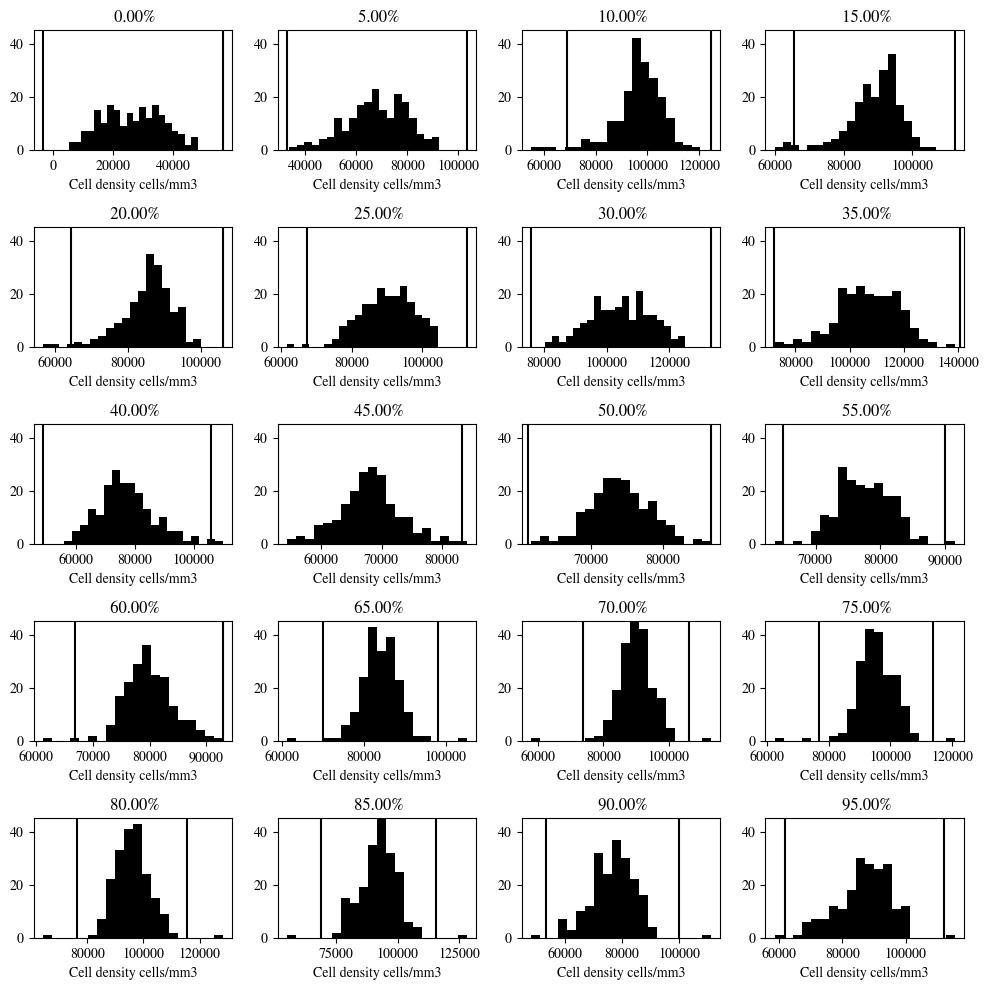

In [25]:
per_percentage_path = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/02022024/Per_percentage/'
file_list = glob.glob(per_percentage_path + '*.csv')
density_df = concate_density_dataframes(file_list)


image_to_exlude_path = ('/gpfs/bbp.cscs.ch/data/project/proj53/LayerBoundariesProject/Analysis/Exclude-ID_v20240206jm.xlsx')
df_image_to_exclude = pd.read_excel(image_to_exlude_path, index_col=0, skiprows=[0,1,2,3,4,5,6,7])
db_image_to_exlude_list = get_image_to_exlude_list(df_image_to_exclude)

# Exclude image for Excel file
db_indice = density_df[(density_df['image'].isin(db_image_to_exlude_list))].index
density_df = density_df.drop(db_indice)

# Exclude image with density outsite N sigma of std
sigma_image_to_exclude = get_image_to_exclude(density_df, nb_sigma=2,
                                              output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/cell densities')
print(f' {len(sigma_image_to_exclude)} images exclude / {len(np.unique(density_df.image))} ')

sigma_indice = density_df[(density_df['image'].isin(sigma_image_to_exclude))].index
density_df = density_df.drop(sigma_indice)


/tmp/ipykernel_13776/2808587699.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/2808587699.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])


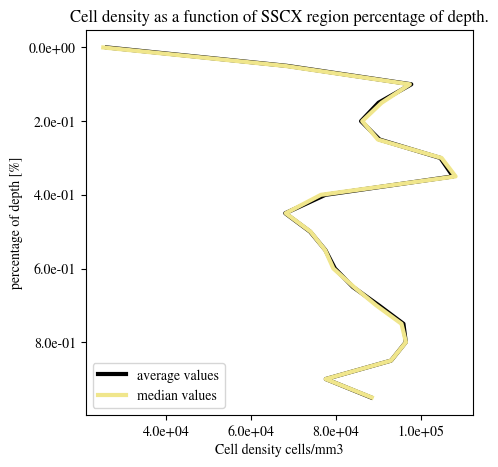

In [11]:
data = dataframe_to_array(density_df)
plot(data, 'Cell density as a function of SSCX region percentage of depth.',
    plot_median=True, plt_detail=False, output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/median_density_percentage.svg')

/tmp/ipykernel_13776/2808587699.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/2808587699.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])


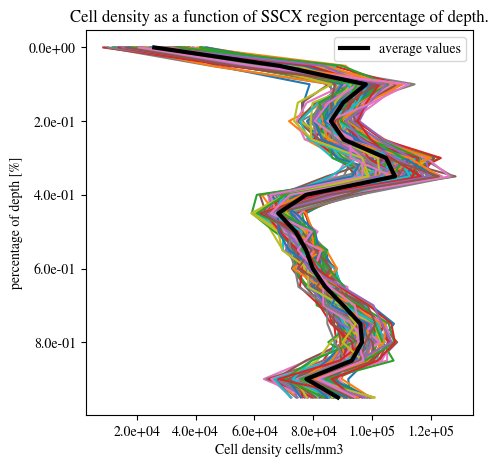

In [12]:
plot(data, 'Cell density as a function of SSCX region percentage of depth.',
     plt_detail=True, output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/full_density_percentage.svg')

/tmp/ipykernel_13776/1117596345.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/1117596345.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


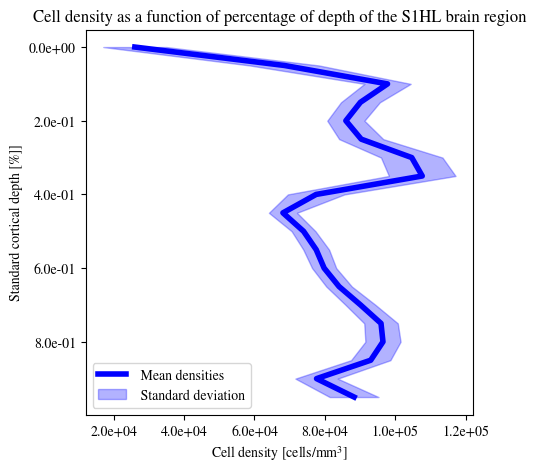

In [13]:
plot_mean_and_std_dev(density_df, 
                      title="Cell density as a function of percentage of depth of the S1HL brain region",
                      output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/full_std_density_percentage.svg')

In [14]:
meta_df = pd.read_csv('/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/20231102/datasets/Exported_Features/Dataframes/metadata.csv', index_col=0)

In [15]:
analyse_df = meta_df[meta_df.Analyze == True]
left_meta_df = analyse_df[analyse_df['hemisphere(L/R)']=='left']
right_meta_df = analyse_df[analyse_df['hemisphere(L/R)']=='right']

In [16]:
left_image_id = list(left_meta_df['Image_Name'])
right_image_id = list(right_meta_df['Image_Name'])
left_density_df = get_filtered_density_df(left_image_id, density_df)
right_density_df = get_filtered_density_df(right_image_id, density_df)

/tmp/ipykernel_13776/2808587699.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/2808587699.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])


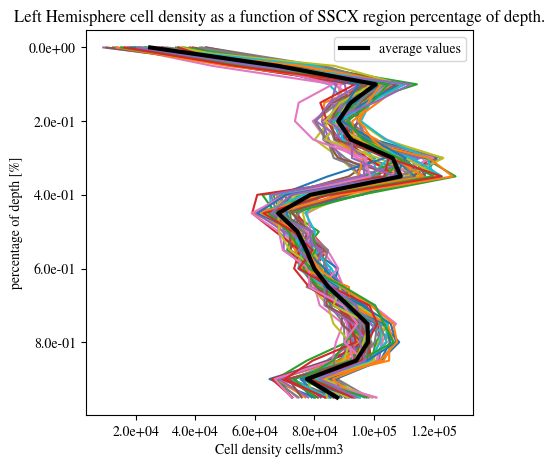

In [17]:
data = dataframe_to_array(left_density_df)
plot(data, 'Left Hemisphere cell density as a function of SSCX region percentage of depth.',
     plt_detail=True,
   output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/left_density_percentage.svg')

/tmp/ipykernel_13776/2808587699.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/2808587699.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])


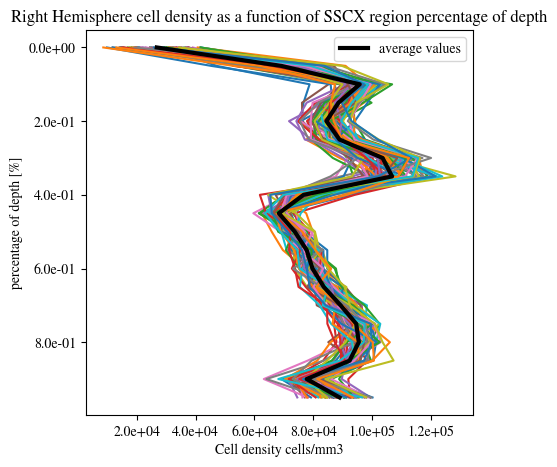

In [18]:
data = dataframe_to_array(right_density_df)
plot(data, 'Right Hemisphere cell density as a function of SSCX region percentage of depth',
     plt_detail=True,
    output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/right_std_density_percentage.svg')

/tmp/ipykernel_13776/1117596345.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/1117596345.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/1117596345.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/1117596345.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


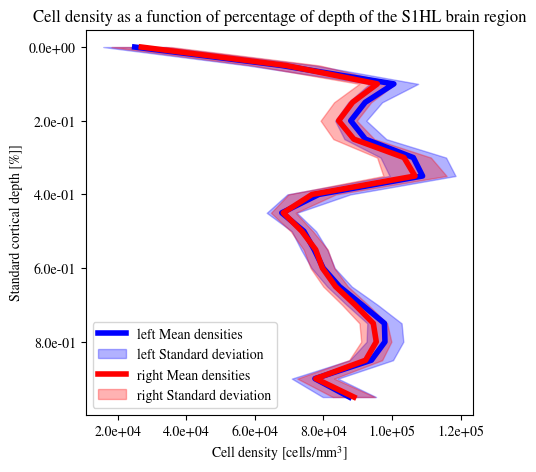

In [19]:
plot_mean_and_std_dev([left_density_df,right_density_df], 
                      labels=['left', 'right'],
                      colors=['blue', 'red'],
                      title="Cell density as a function of percentage of depth of the S1HL brain region",
                      output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/left_right_std_density_percentage.svg')


In [20]:
project_ID_list = np.unique(analyse_df['Project_ID'])

/tmp/ipykernel_13776/1117596345.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/1117596345.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/2808587699.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/2808587699.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_xticklabels(['{:.1e}'.format(x) for x in current_values])
/tmp/ipykernel_13776/1117596

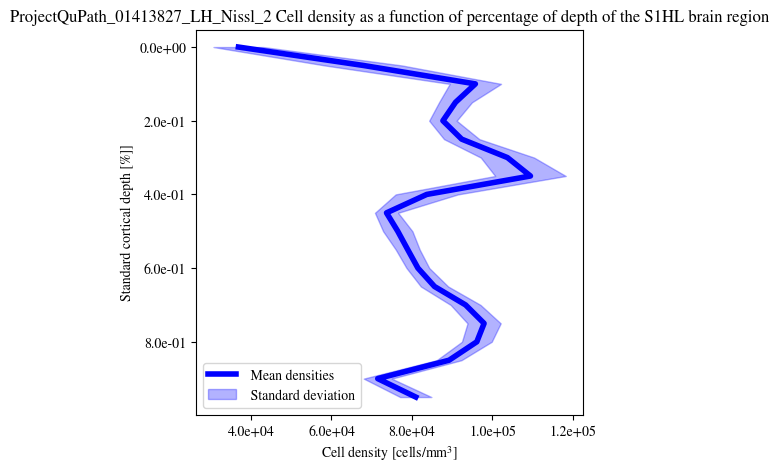

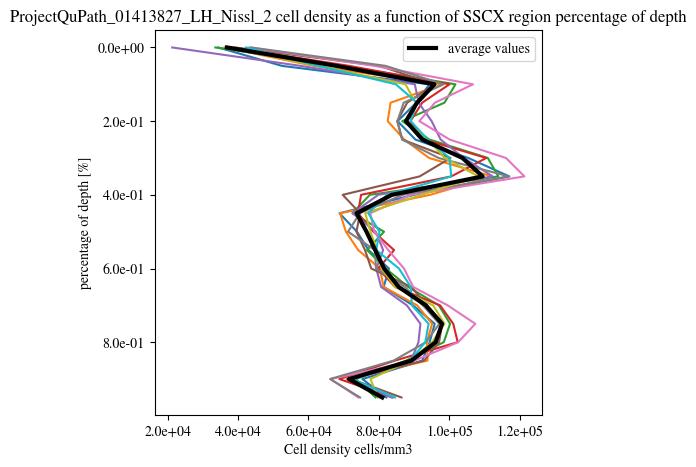

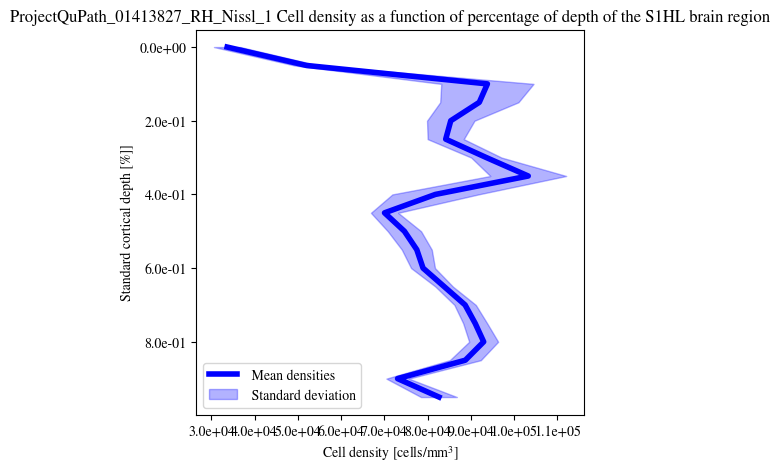

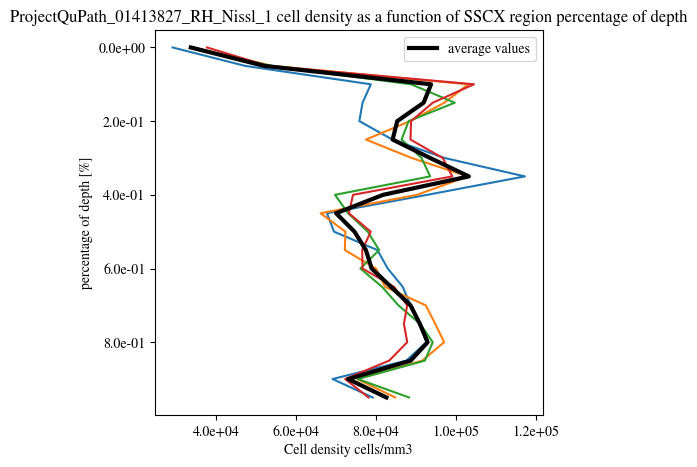

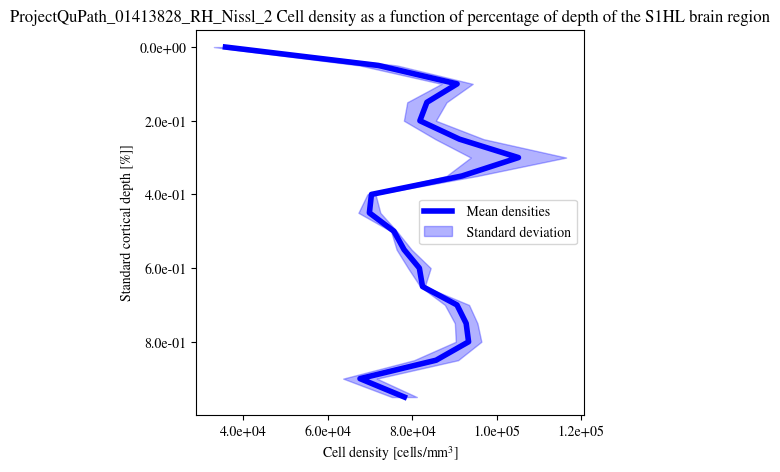

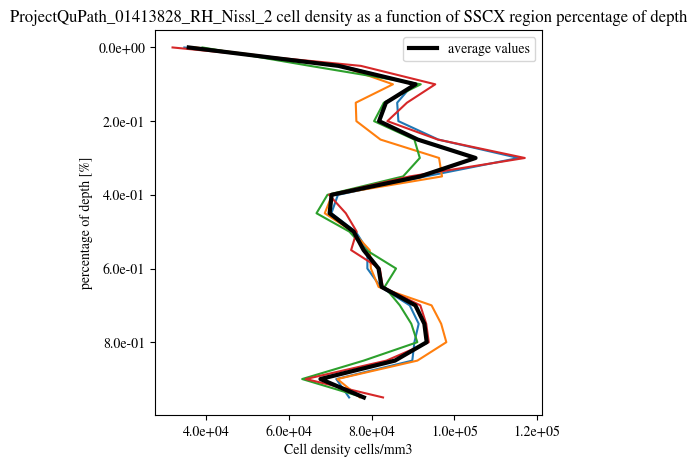

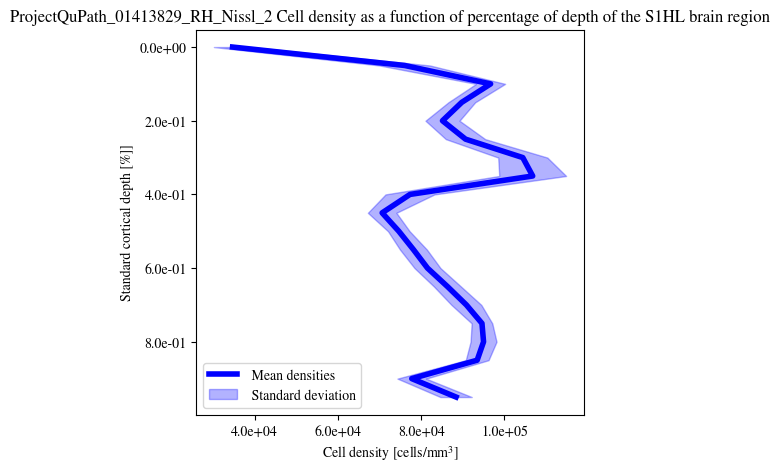

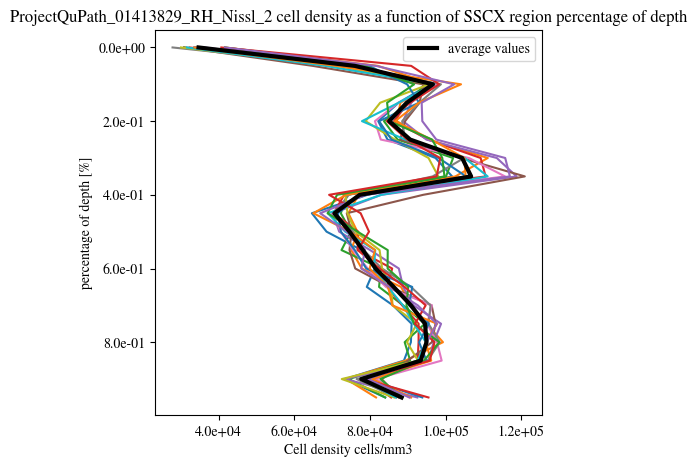

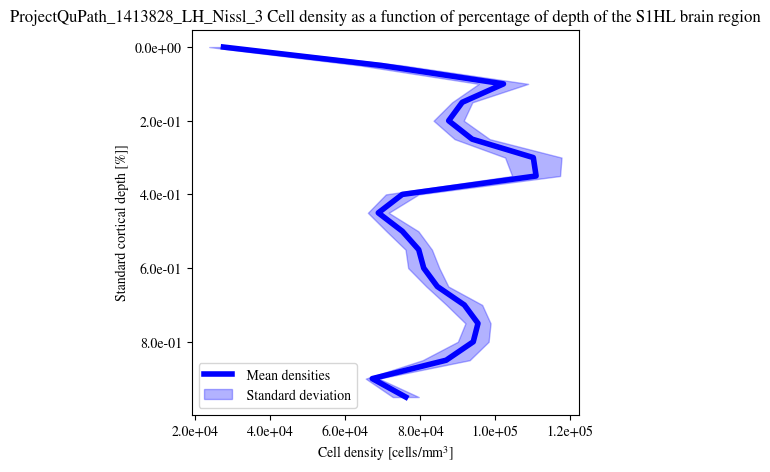

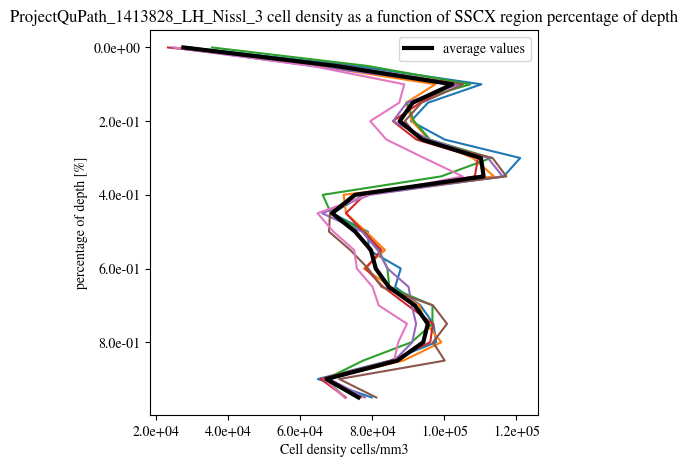

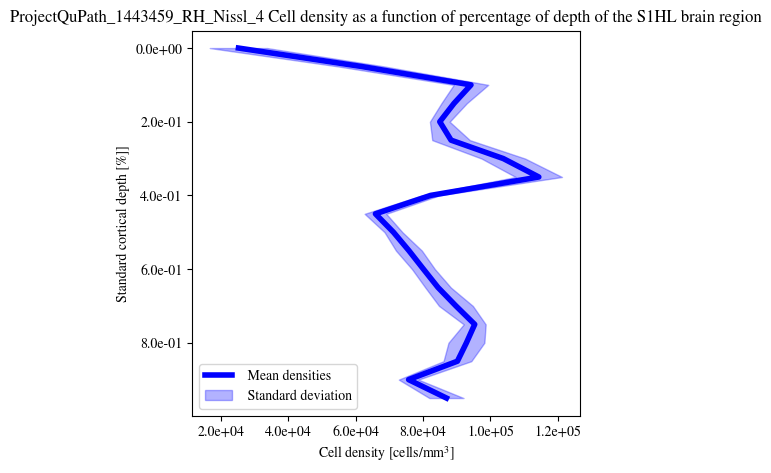

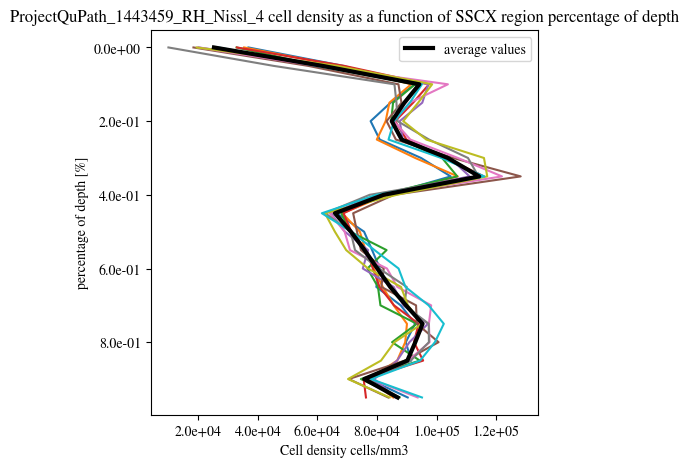

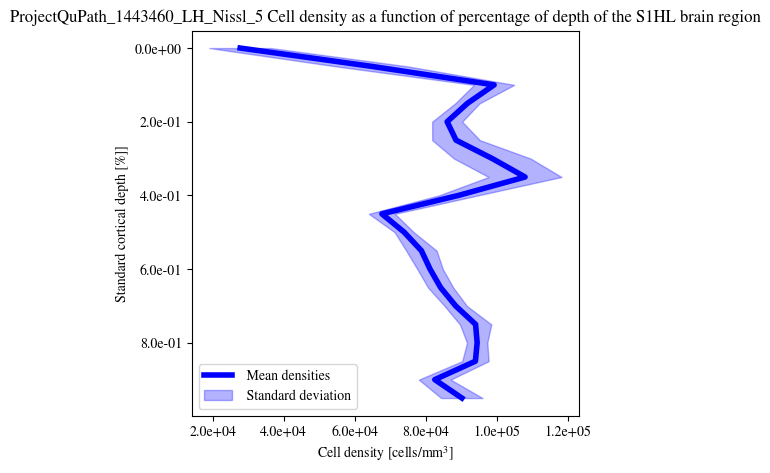

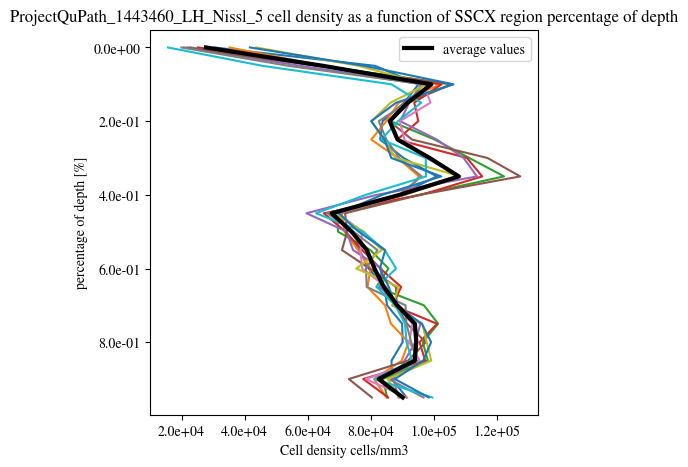

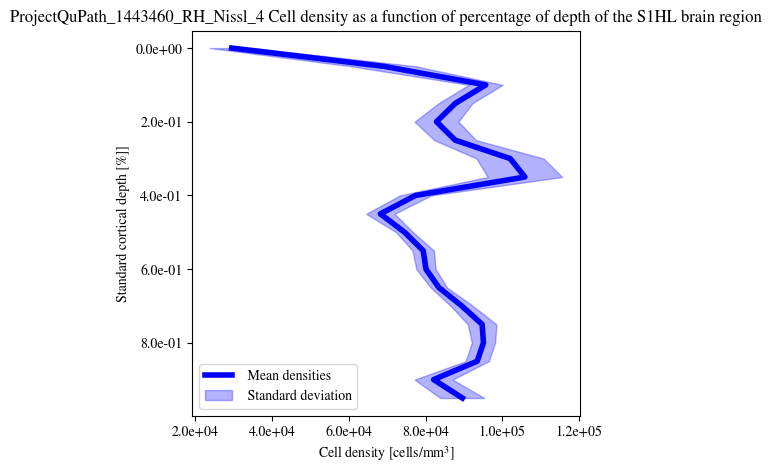

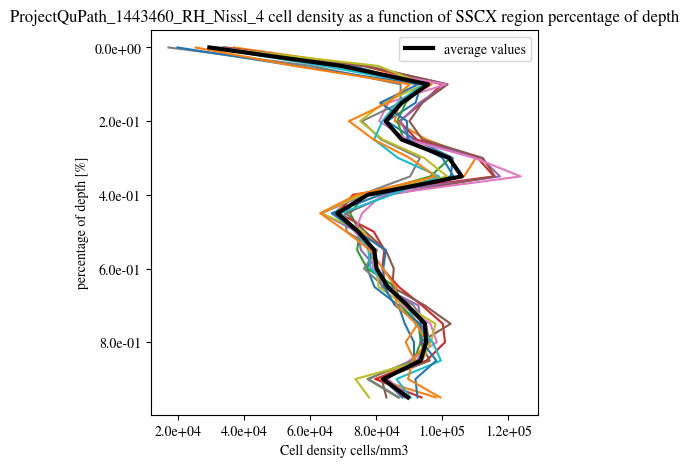

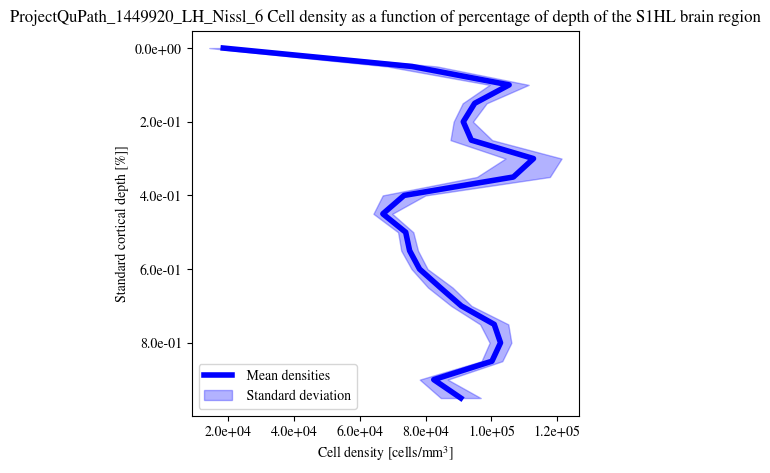

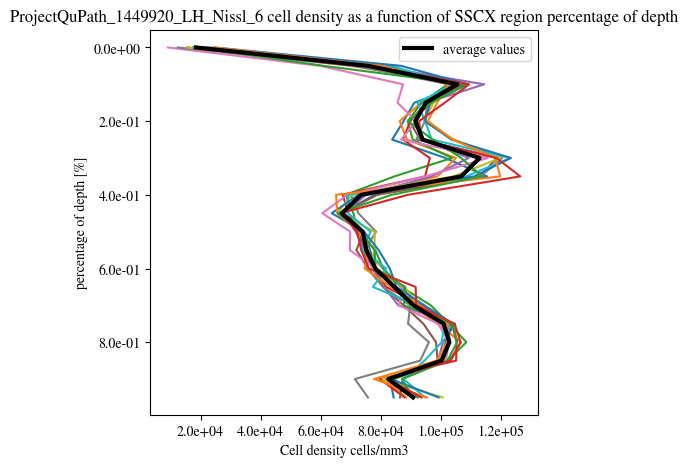

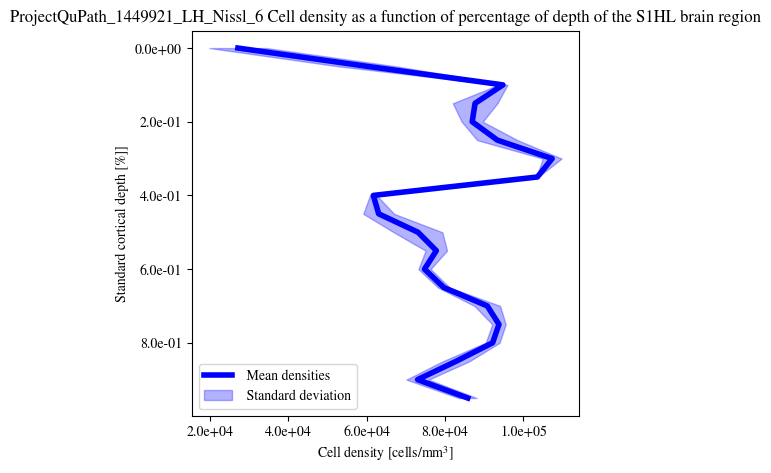

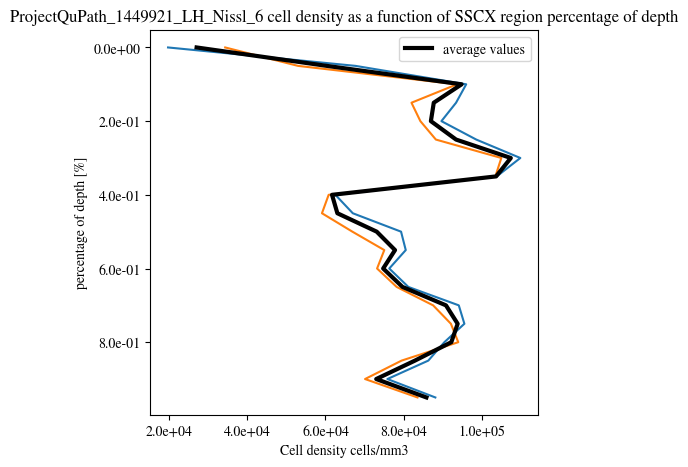

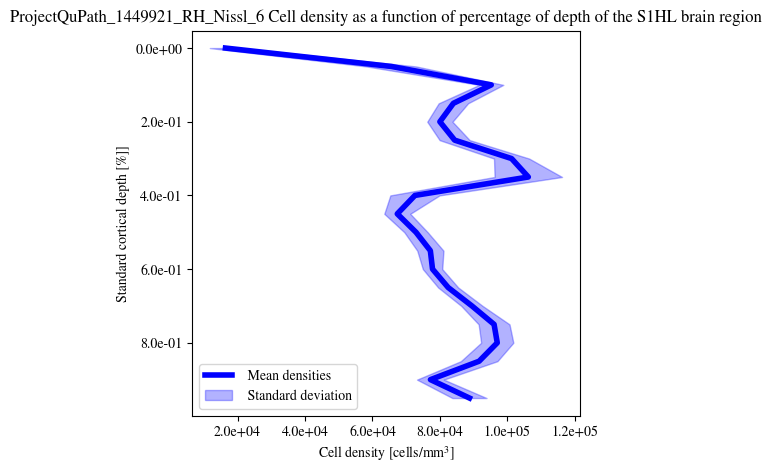

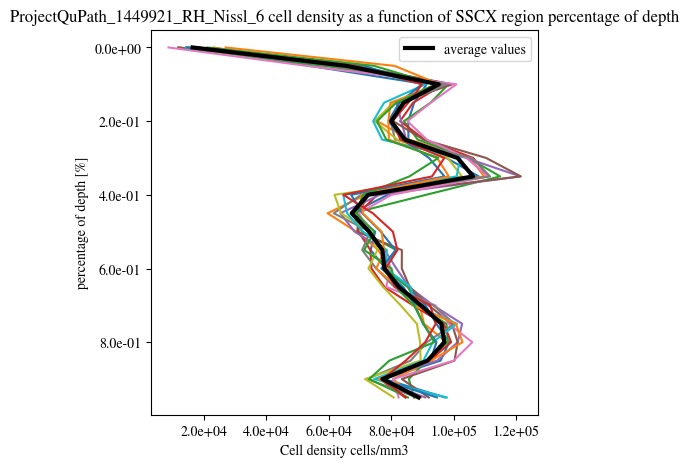

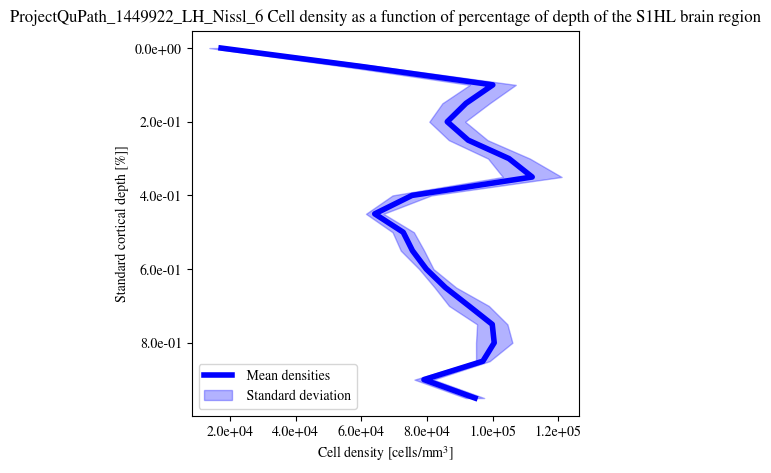

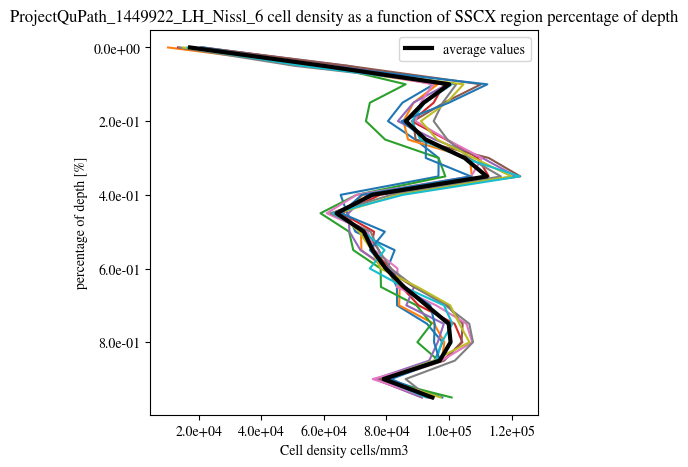

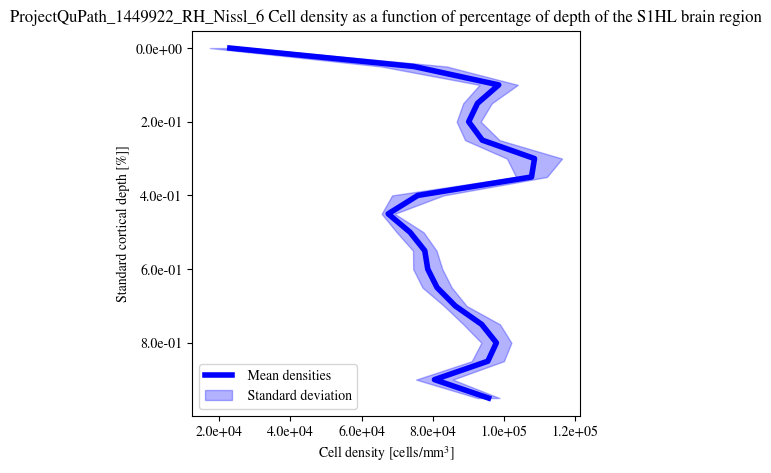

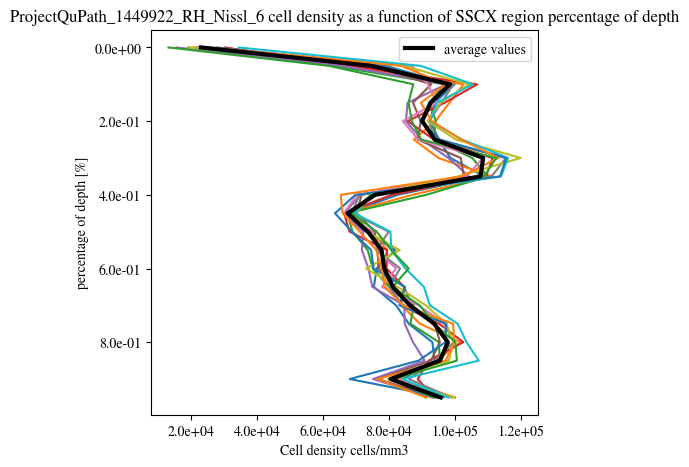

In [21]:
for project_id in project_ID_list:
    animal_meta_df = analyse_df[analyse_df['Project_ID']==project_id]
    animal_image_id = list(animal_meta_df['Image_Name'])
    animal_density_df = get_filtered_density_df(animal_image_id, density_df)
    data = dataframe_to_array(animal_density_df)
    plot_mean_and_std_dev([animal_density_df], 
                      title=f"{project_id} Cell density as a function of percentage of depth of the S1HL brain region")
    plot(data, f'{project_id} cell density as a function of SSCX region percentage of depth', plt_detail=True,
        output_path=f'/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/{project_id}_std_density_percentage.svg')

# Density per layers

In [22]:
path = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/02022024/Per_Layer/Merged_second_layer_prediction//'
layer_df = get_per_layer_df(path)

ind [0 1 2 3 4 5] , columns ['Layer 1', 'Layer 2/3', 'Layer 4', 'Layer 5', 'Layer 6 a', 'Layer 6 b']


/tmp/ipykernel_13776/1125904926.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


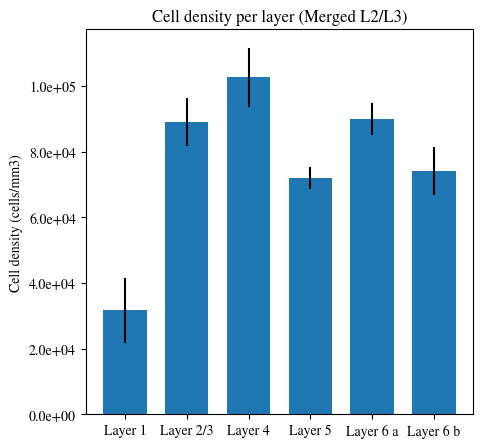

In [23]:
plot_density_per_layer(layer_df,
                       title='Cell density per layer (Merged L2/L3)',
                      output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/per_layer_merge_23.svg')

In [35]:
path_d = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/02022024/Per_Layer/Distinguishable_second_layer_prediction/'
layer_df = get_per_layer_df(path_d)

/tmp/ipykernel_13776/2915626501.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


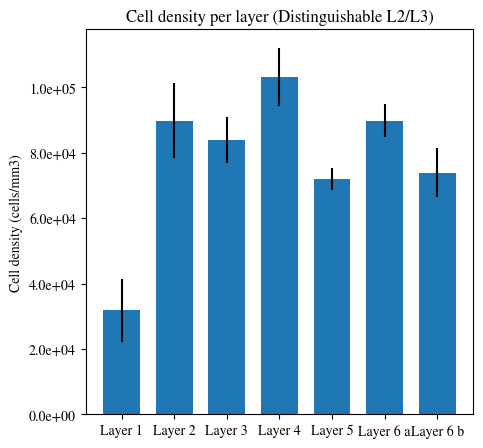

In [36]:
plot_density_per_layer(layer_df,
                     title='Cell density per layer (Distinguishable L2/L3)',
                      output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/per_layer_distinguish_23.svg')

In [37]:
path_d = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/02022024/Per_Layer/Per_layer_from_GT/'
layer_df_gt = get_per_layer_df(path_d)
# Remove Merged Layer2/3 dataset


/tmp/ipykernel_13776/2915626501.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])


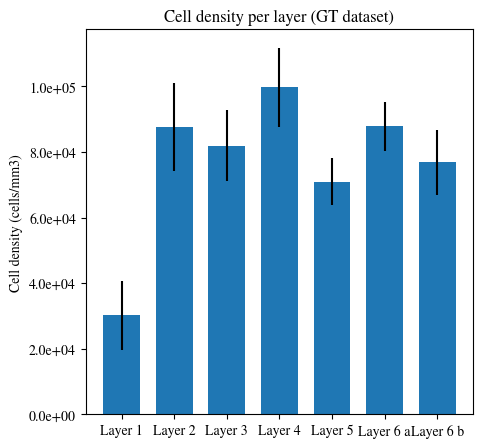

In [38]:
plot_density_per_layer(layer_df_gt,
                       title='Cell density per layer (GT dataset)',
                      output_path='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/31012024/per_layer_GT.svg')

In [44]:
(layer_df.mean(axis=0) - layer_df_gt.mean(axis=0)) / layer_df.mean(axis=0) * 100

Layer 1      5.376513
Layer 2      2.600442
Layer 3      2.456946
Layer 4      3.426750
Layer 5      1.392076
Layer 6 a    2.301283
Layer 6 b   -3.912806
dtype: float64

In [43]:
layer_df.mean(axis=0)

Layer 1       31863.694290
Layer 2       89847.178477
Layer 3       83908.747125
Layer 4      103183.013872
Layer 5       71946.914241
Layer 6 a     89845.508219
Layer 6 b     73900.820428
dtype: float64